In [1]:
import cvxpy as cp
import numpy as np
from drone_model import DroneModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import trajectory

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['axes.grid'] = True

In [2]:
N = 18 #18
n_states = 12
n_inputs = 4

x0 = np.array([0,0,15,0,0,0])

#x_ref = trajectory.straight_line(220, 20, 0, 50,0)
x_ref = trajectory.sine_wave(220, 15, 0, 15, 0)
#x_ref = trajectory.helix(200, 10, 5, 20, 4)
#x_ref = trajectory.figure8(200,15,10)
#x_ref = trajectory.spiral(200,0,10)
#x_ref = trajectory.setpoint(200, 10, 5, 5)
#x_ref = trajectory.zigzag(200,15,2,2)
#x_ref = trajectory.step_change(200, 10, 1)

C = np.array([
    [1,0,0,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0,0,0],
])

#Qranges = np.square([300,300,300,1.57,1.57,6.28,45,15,10,10,10,5])
Qranges = np.square([300,300,300])
Rranges = np.square([40,3,3,1])

#Q = np.diag([1,1,1,1,1,1,1,1,1,1,1,1]/Qranges)
Q = np.diag([1,1,1]/Qranges) * 150
R = np.diag([1,1,1,1]/Rranges)

In [3]:
from nonlinear_drone import NLDroneModel
STEPS = 200
Ts = 0.1
plant = DroneModel(Ts=Ts)
predictor = DroneModel(Ts=Ts)
plant_states = np.zeros((n_states,STEPS+1))
plant_states[:,0] = np.concatenate((x0,[0,0,0,0,0,0]))
inputs = np.zeros((n_inputs,STEPS+1))
T = 0
for t in tqdm(range(STEPS),desc='Running Simulation...'):
    tdisturbance = np.zeros((n_states,))
    if t>100 and t <110: 
        tdisturbance[3] = 5
        tdisturbance[4] =5
        tdisturbance[5] =5
    current_state = plant_states[:,t]
    if t == 0:
        predictor.computeA(current_state)
        plant.computeA(current_state)
        filtered_state = current_state
    else:
        alpha = 0.3
        filtered_state = alpha*current_state + (1-alpha)*plant_states[:,t-1]
    
    x = cp.Variable((n_states, N+1))
    u = cp.Variable((n_inputs, N))
    constraints = [x[:,0] == filtered_state]
    cost = 0
    for k in range(N):
        disturbance = np.zeros((n_states,))
        disturbance[3] = np.sin(0.1*T) + np.random.normal(0,0.1)
        disturbance[5] = np.cos(0.1*T) + np.random.normal(0,0.1)
        ref_k = x_ref[:, min(t + k, x_ref.shape[1] - 1)]
        cost += cp.quad_form(C @ x[:,k] - ref_k, Q) + cp.quad_form(u[:,k],R)
        constraints += [
            x[:,k+1] == predictor.discrete_dynamics(x[:,k],u[:,k]), #+ disturbance*Ts,
            x[6:9,k] <= 10,
            x[6:9,k] >= -10,
            cp.norm(u[:,k], np.inf) <= 5
            ]
    objective = cp.Minimize(cost)    
    prob = cp.Problem(objective, constraints)
    prob.solve()
    if prob.status not in ["infeasible", "unbounded"]:
        optimal_u = u[:,0].value
        plant_states[:,t+1] = plant.step(current_state, optimal_u,Ts) #+ tdisturbance*Ts
        inputs[:,t] = optimal_u
    else:
        print(f"\nProblem at step {t} is {prob.status}")
        optimal_u = inputs[:,t-1]
        plant_states[:,t+1] = plant.step(current_state, optimal_u,Ts) #+ tdisturbance*Ts
        inputs[:,t] = optimal_u
        continue

Running Simulation...: 100%|██████████| 200/200 [00:34<00:00,  5.73it/s]


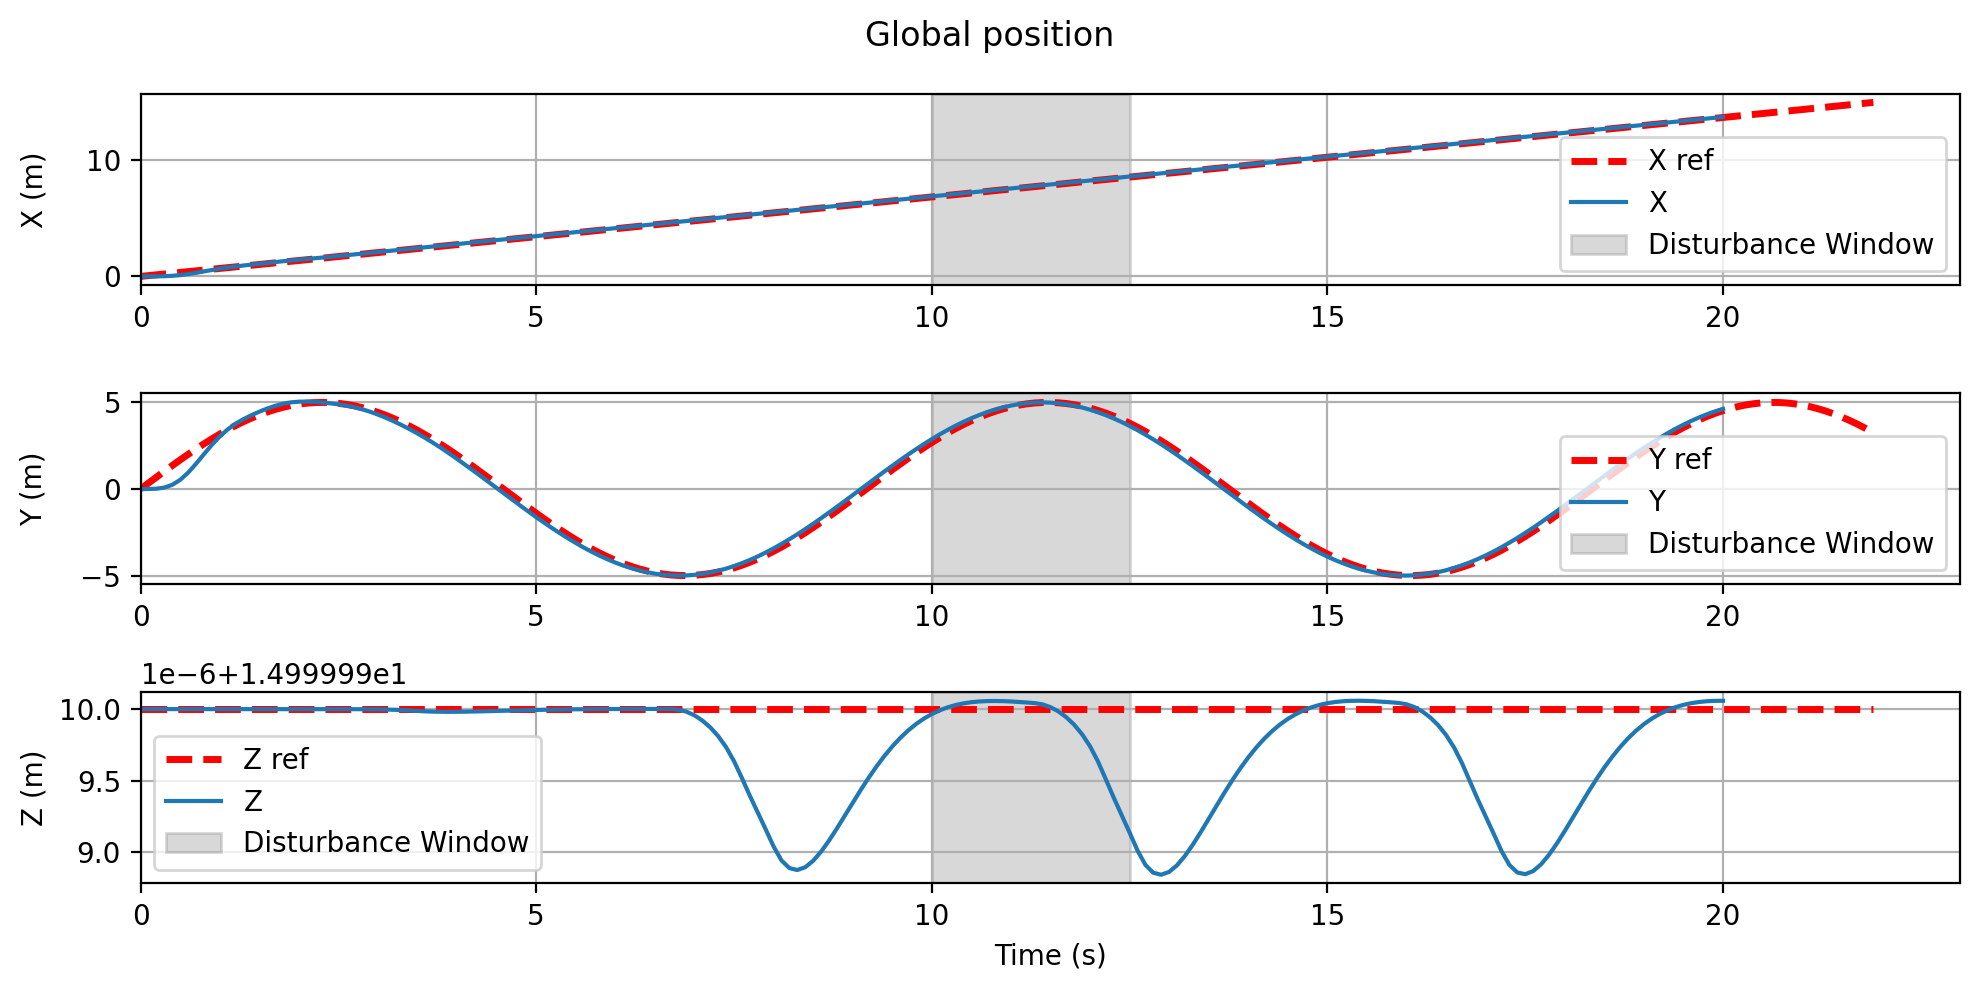

In [4]:
figure, ax = plt.subplots(3, 1)

labels = ['X', 'Y', 'Z']

for i in range(len(ax)):
    ax[i].plot(np.arange(x_ref.shape[1]) * Ts, x_ref[i, :], '--', color='r', label=f'{labels[i]} ref', linewidth=2.5)
    ax[i].plot(np.arange(plant_states.shape[1]) * Ts, plant_states[i, :], label=f'{labels[i]}')
    ax[i].axvspan(10, 12.5, color='gray', alpha=0.3, label='Disturbance Window')  # Add shaded window
    ax[i].set_ylabel(f'{labels[i]} (m)')
    ax[i].set_xlim(0)
    ax[i].legend()
ax[-1].set_xlabel('Time (s)')
figure.suptitle('Global position')
figure.tight_layout()
figure.align_labels()
plt.show()

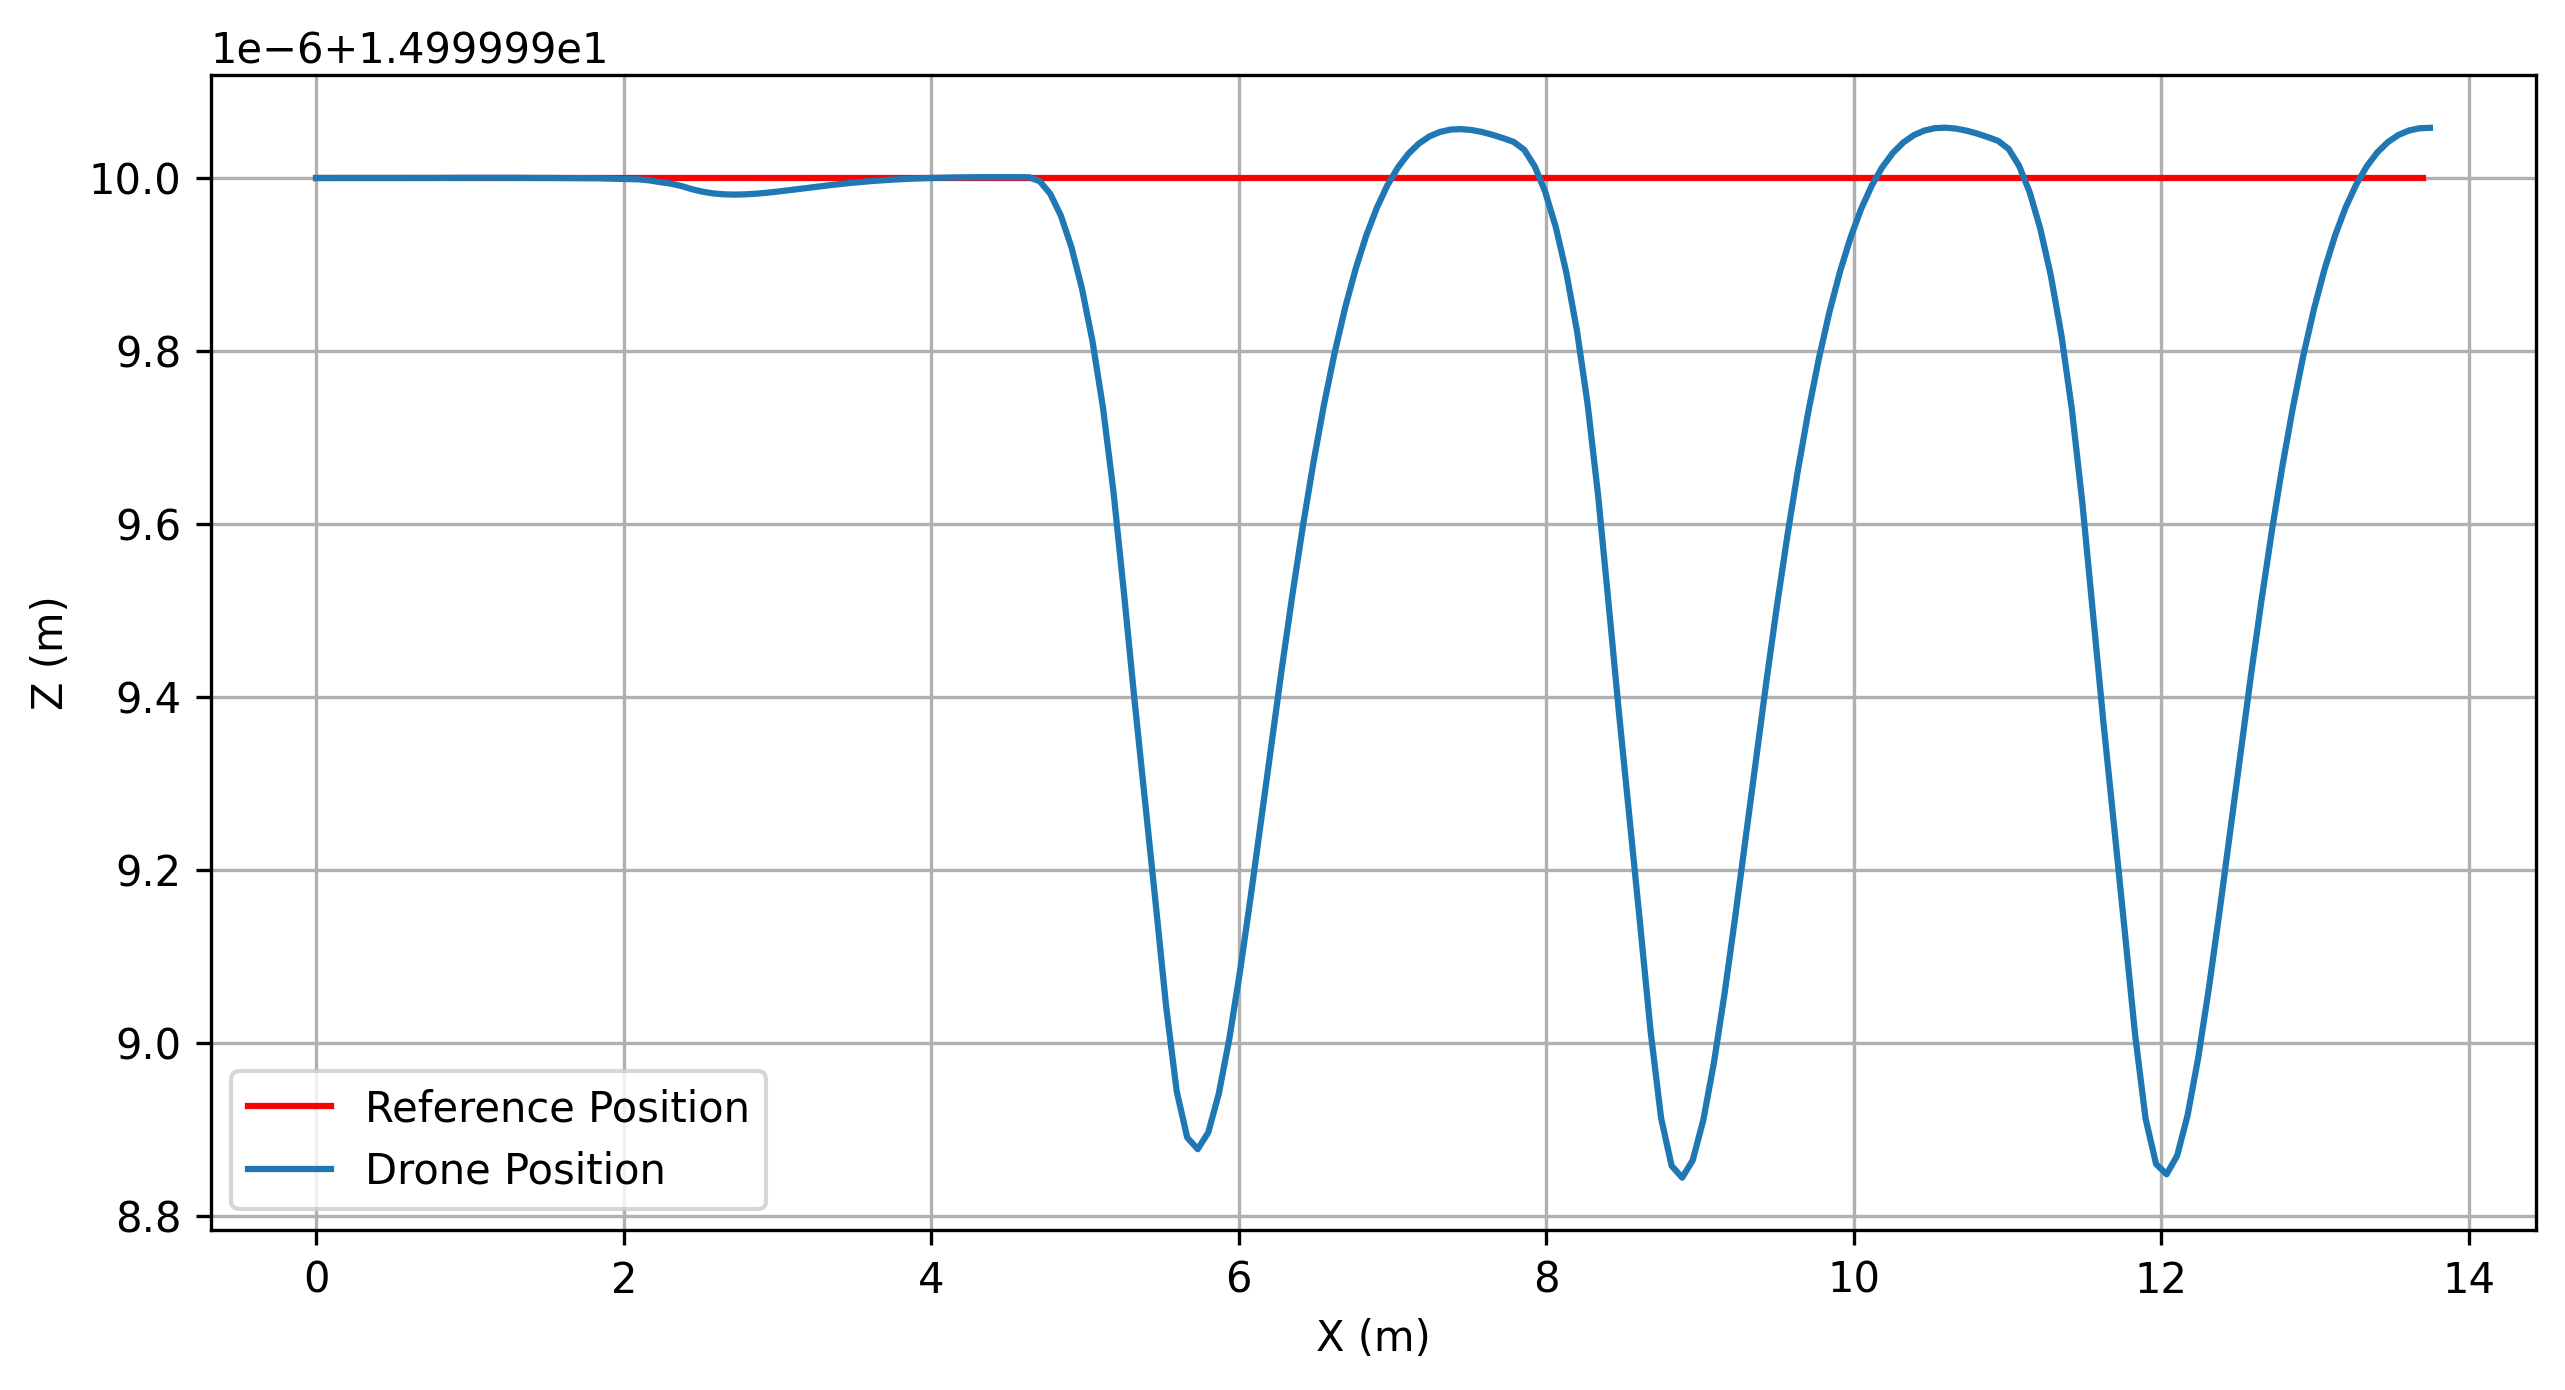

In [5]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)
ax.plot(x_ref[0,:-19],x_ref[2,:-19],label='Reference Position',color='r')
ax.plot(plant_states[0,:],plant_states[2,:],label='Drone Position')
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)')
ax.legend()
plt.show()

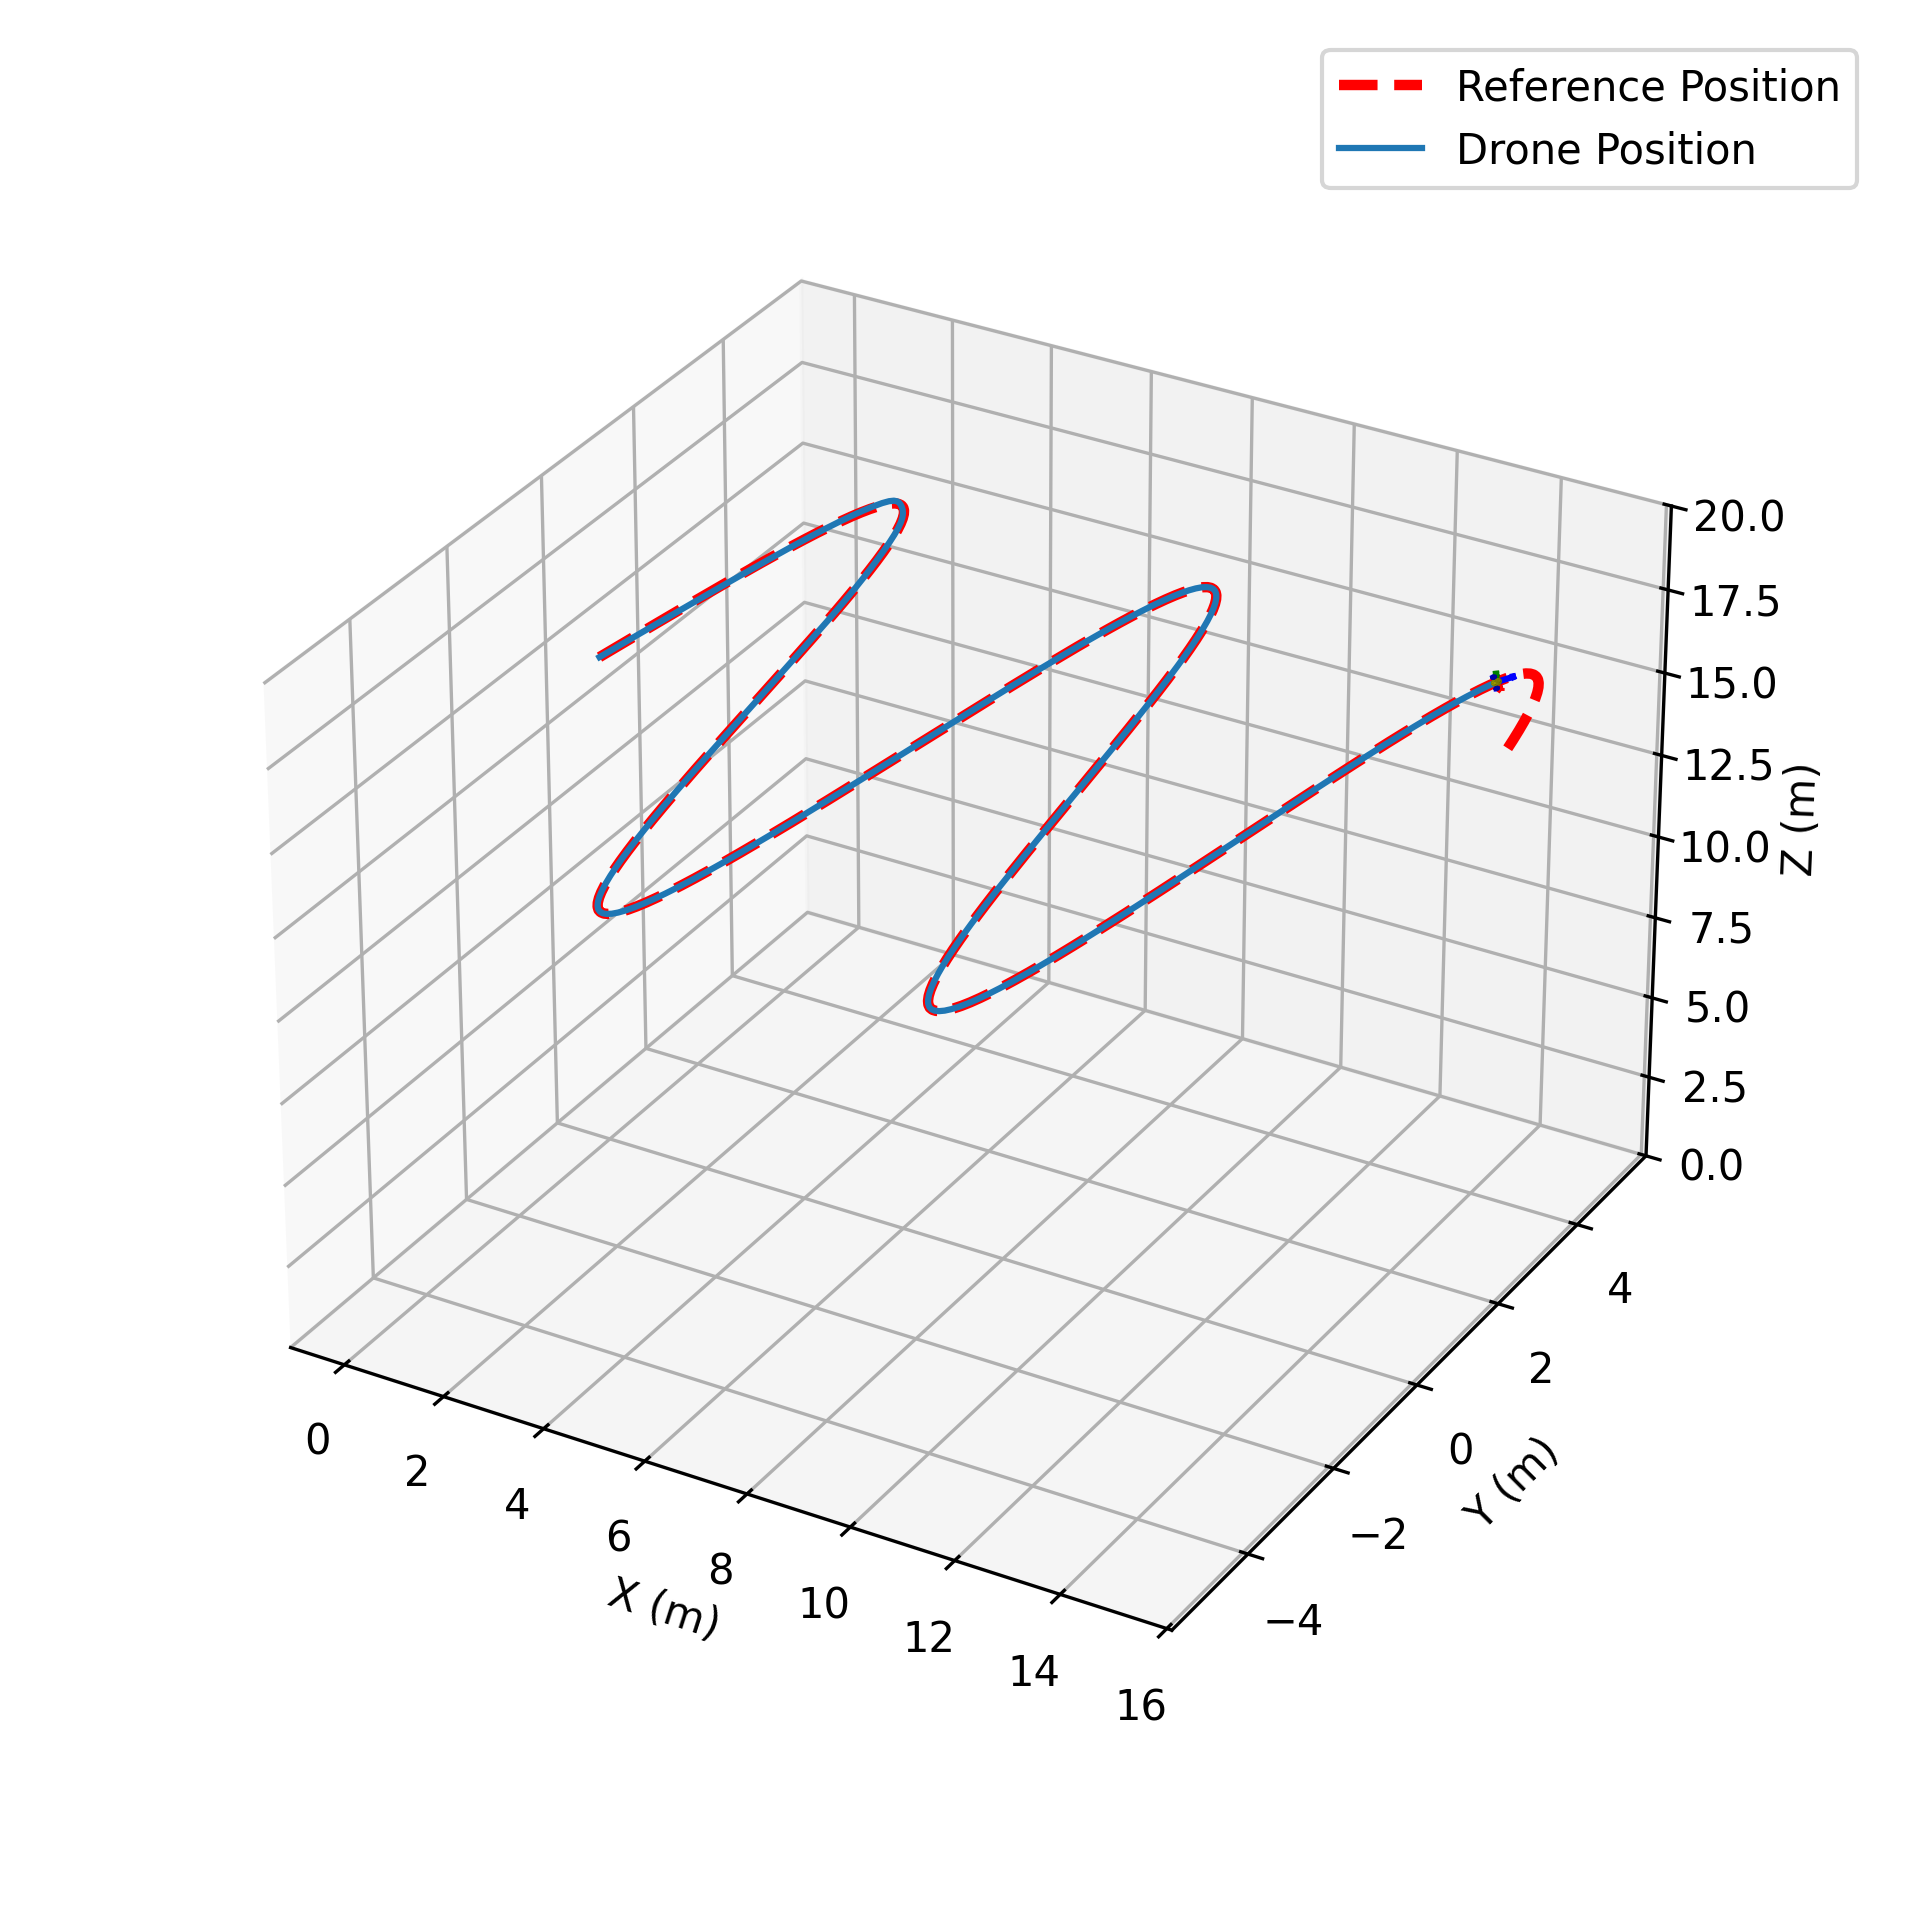

In [6]:
from pyplot3d.uav import Uav
from pyplot3d.utils import ypr_to_R
arm_length = 0.17


fig = plt.figure(dpi=300, figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

uav = Uav(ax, arm_length)
uav.draw_at(plant_states[:3,-1], ypr_to_R(plant_states[3:6,-1]))

ax.plot(x_ref[0,:], x_ref[1,:], x_ref[2,:],'--', color='r', label='Reference Position',linewidth=2.5)
ax.plot(plant_states[0,:], plant_states[1,:], plant_states[2,:], label='Drone Position')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_zlim(0, 20)
ax.legend()
ax.set_box_aspect(None, zoom=0.85)
plt.show()

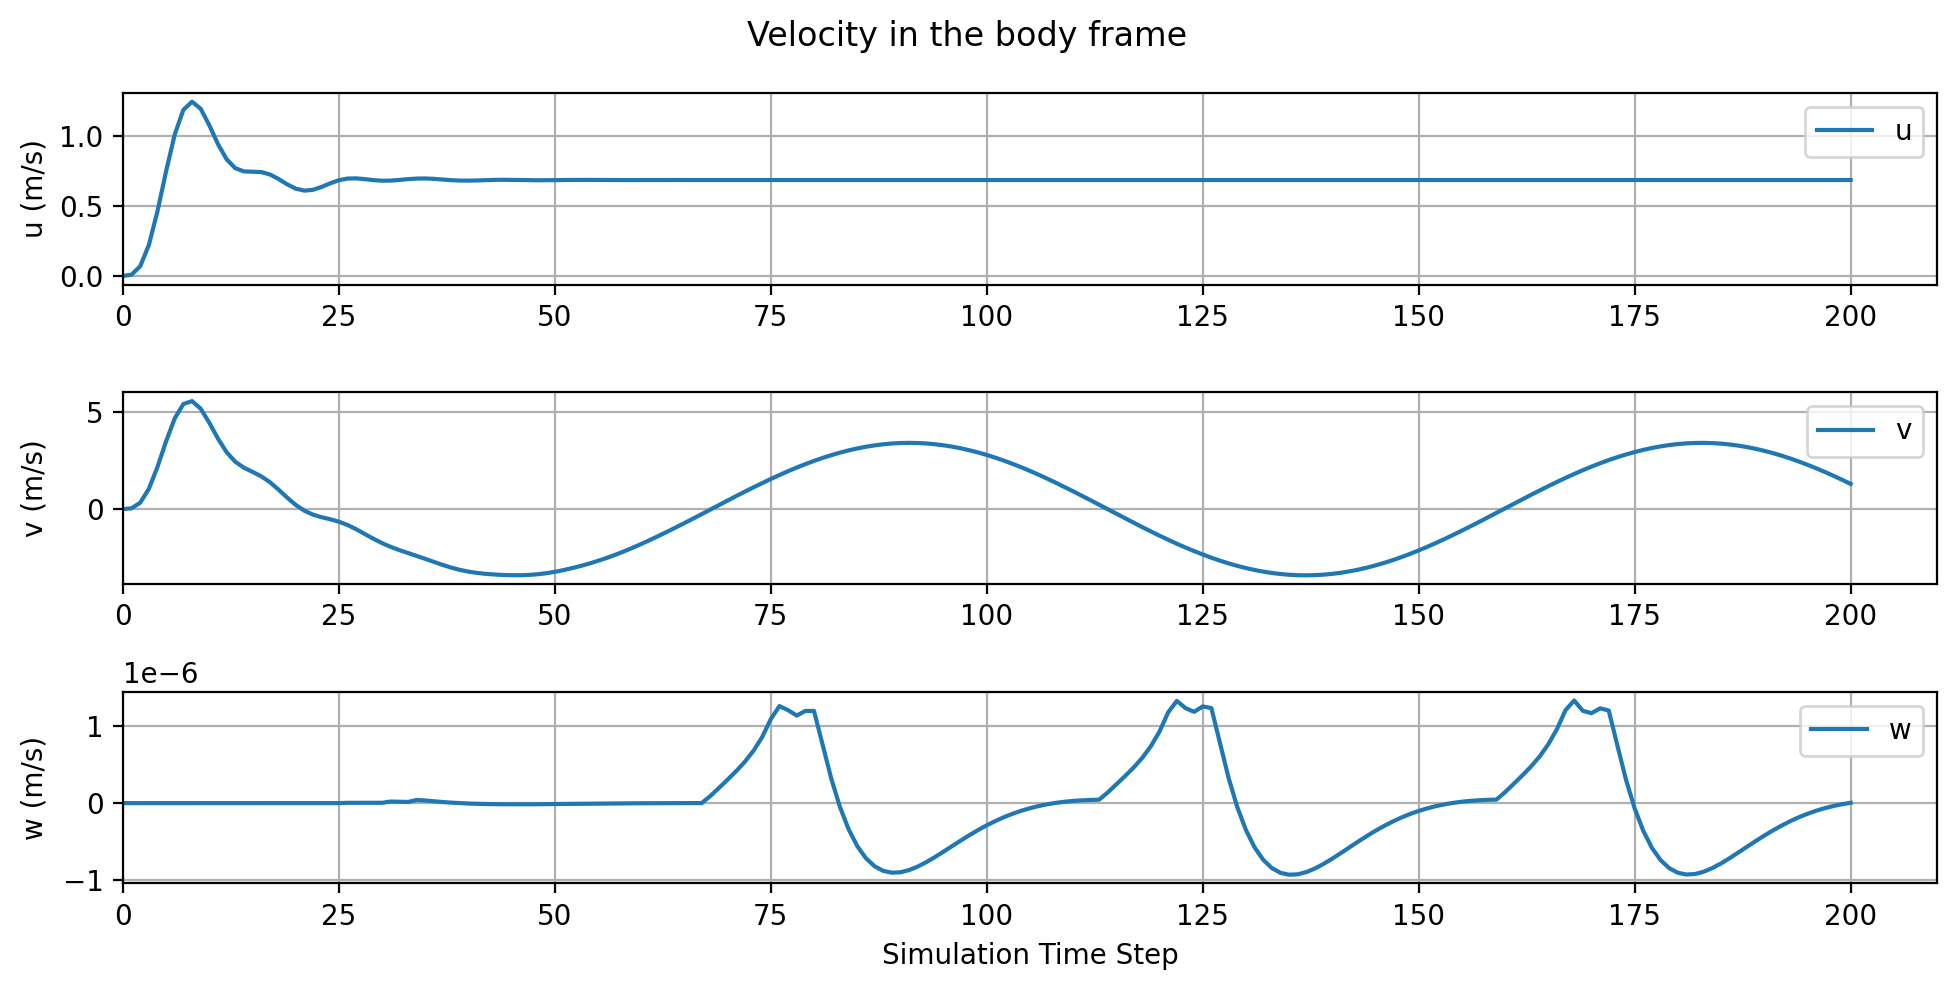

In [7]:
figure, ax = plt.subplots(3,1)
labels = ['u','v','w']
for i in range(len(ax)):
    ax[i].plot(plant_states[3+i,:],label=f'{labels[i]}')
    #ax[i].axhline(x_ref[3+i],label=f'{labels[i]} ref',color='r')
    #ax[i].plot(x_ref[3+i,:],color='r',label=f'{labels[i]} ref')
    ax[i].set_ylabel(f'{labels[i]} (m/s)')
    ax[i].set_xlim(0)
    ax[i].legend()
ax[-1].set_xlabel('Simulation Time Step')
figure.suptitle('Velocity in the body frame')
figure.tight_layout()
figure.align_labels()
plt.show()

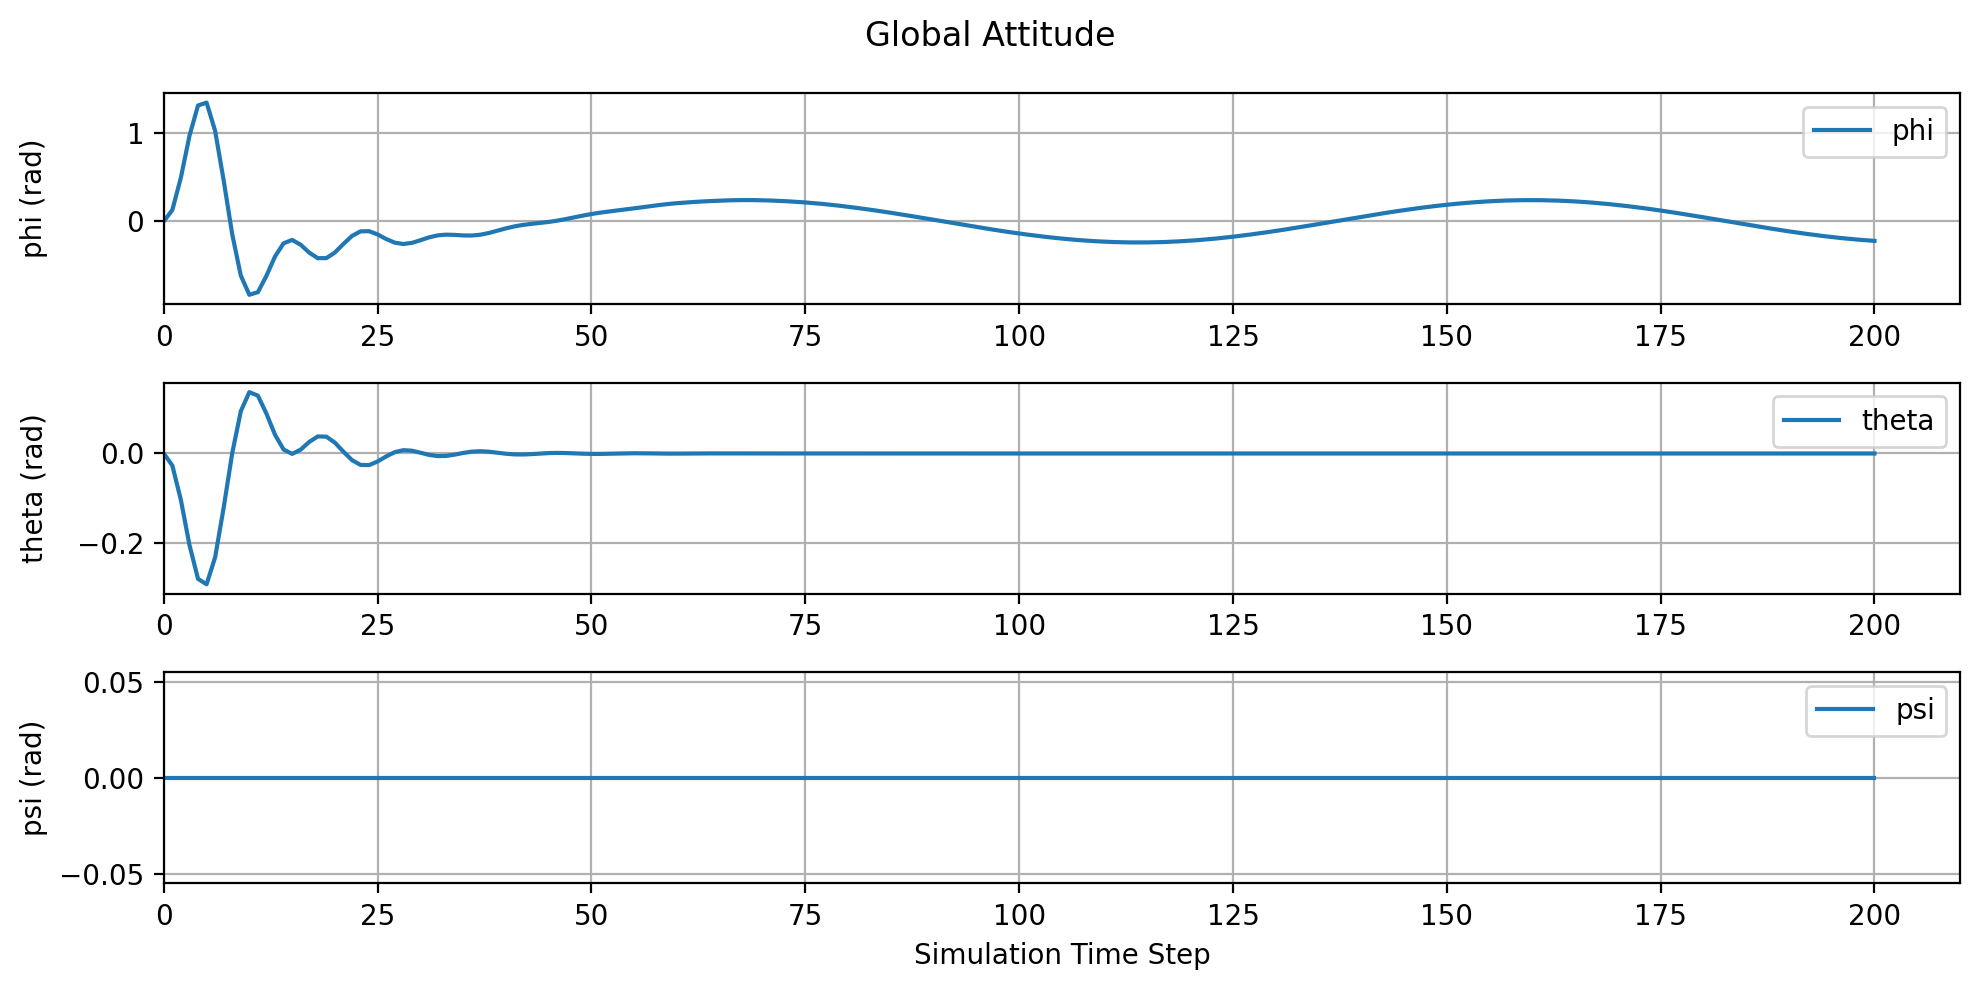

In [8]:
figure, ax = plt.subplots(3,1)
labels = ['phi','theta','psi']
for i in range(len(ax)):
    ax[i].plot(plant_states[6+i,:],label=f'{labels[i]}')
    #ax[i].axhline(x_ref[6+i],label=f'{labels[i]} ref',color='r')
    ax[i].set_ylabel(f'{labels[i]} (rad)')
    ax[i].set_xlim(0)
    ax[i].legend()
ax[-1].set_xlabel('Simulation Time Step')
figure.suptitle('Global Attitude')
figure.tight_layout()
figure.align_labels()
plt.show()

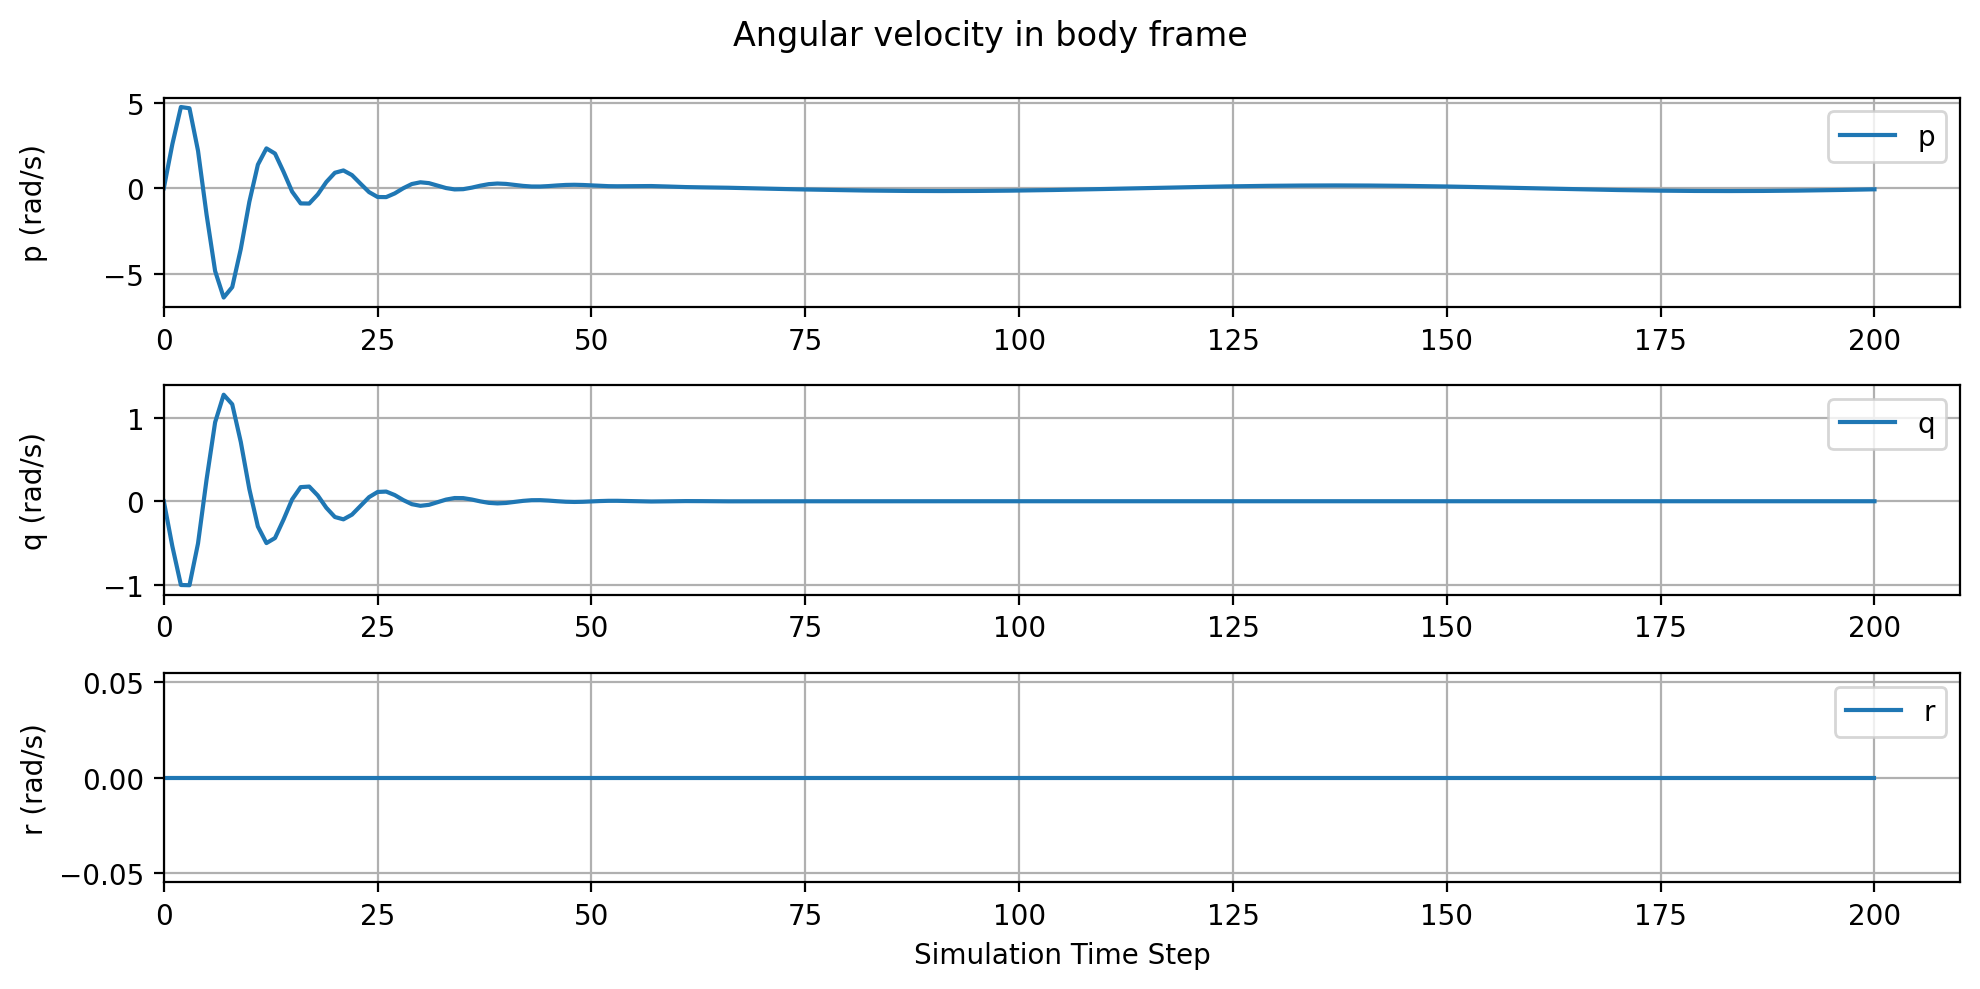

In [9]:
figure, ax = plt.subplots(3,1)
labels = ['p','q','r']
for i in range(len(ax)):
    ax[i].plot(plant_states[9+i,:],label=f'{labels[i]}')
    #ax[i].axhline(x_ref[9+i],label=f'{labels[i]} ref',color='r')
    ax[i].set_ylabel(f'{labels[i]} (rad/s)')
    ax[i].set_xlim(0)
    ax[i].legend()
ax[-1].set_xlabel('Simulation Time Step')
figure.suptitle('Angular velocity in body frame')
figure.tight_layout()
figure.align_labels()
plt.show()

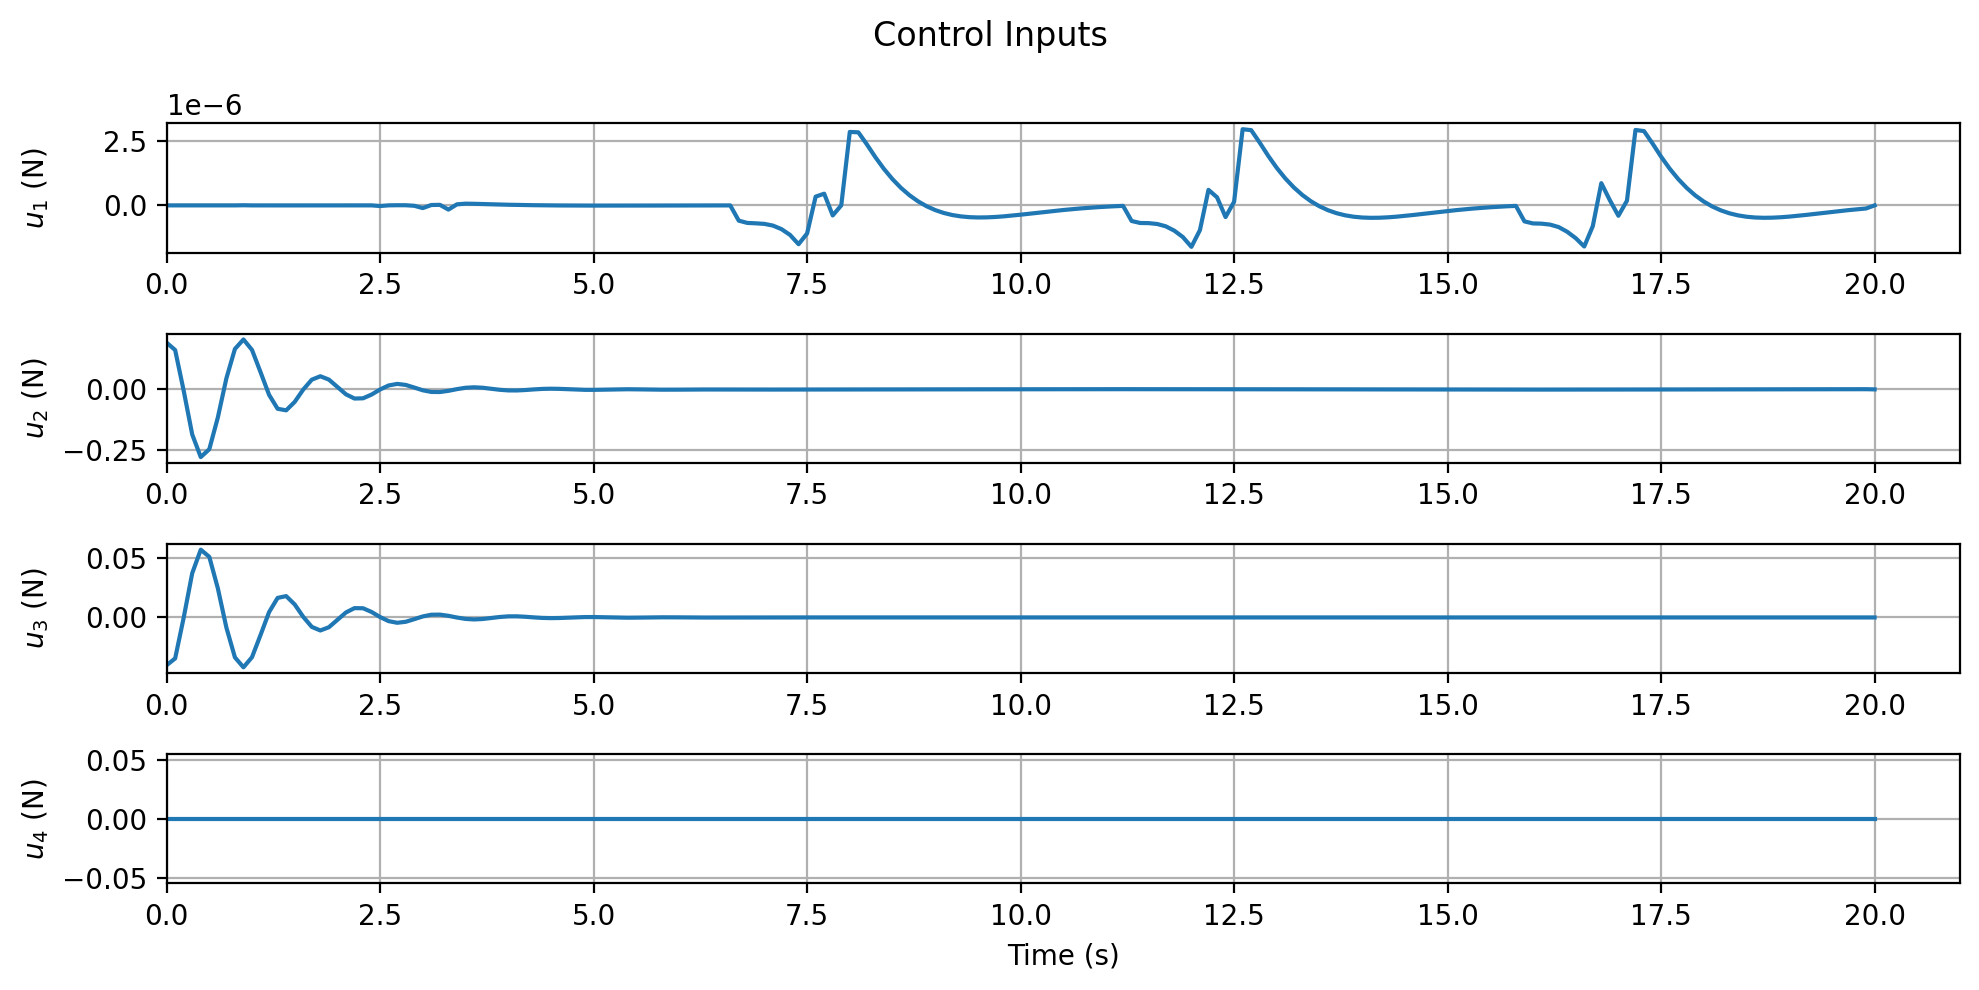

In [10]:
figure, ax = plt.subplots(4,1)

labels = ['$u_{1}$','$u_{2}$','$u_{3}$','$u_{4}$']
for i in range(len(ax)):
    ax[i].plot(np.arange(inputs.shape[1])*Ts,inputs[i,:])
    ax[i].set_ylabel(f'{labels[i]} (N)')
    ax[i].set_xlim(0)
ax[-1].set_xlabel('Time (s)')
figure.suptitle('Control Inputs')
figure.tight_layout()
figure.align_labels()
plt.show()

In [11]:
pos_error = plant_states[:3,1:] - x_ref[:,119:]
rmse = np.sqrt(np.mean(np.square(pos_error),axis=1))
print(f"RMSE: {rmse}")

ValueError: operands could not be broadcast together with shapes (3,200) (3,101) 

In [ ]:
settling_time = np.argmax(np.abs(pos_error) < 0.1, axis=1)
settling_time = np.max(settling_time) * Ts
print(f"Settling time: {settling_time:.2f} s")

Settling time: 1.70 s


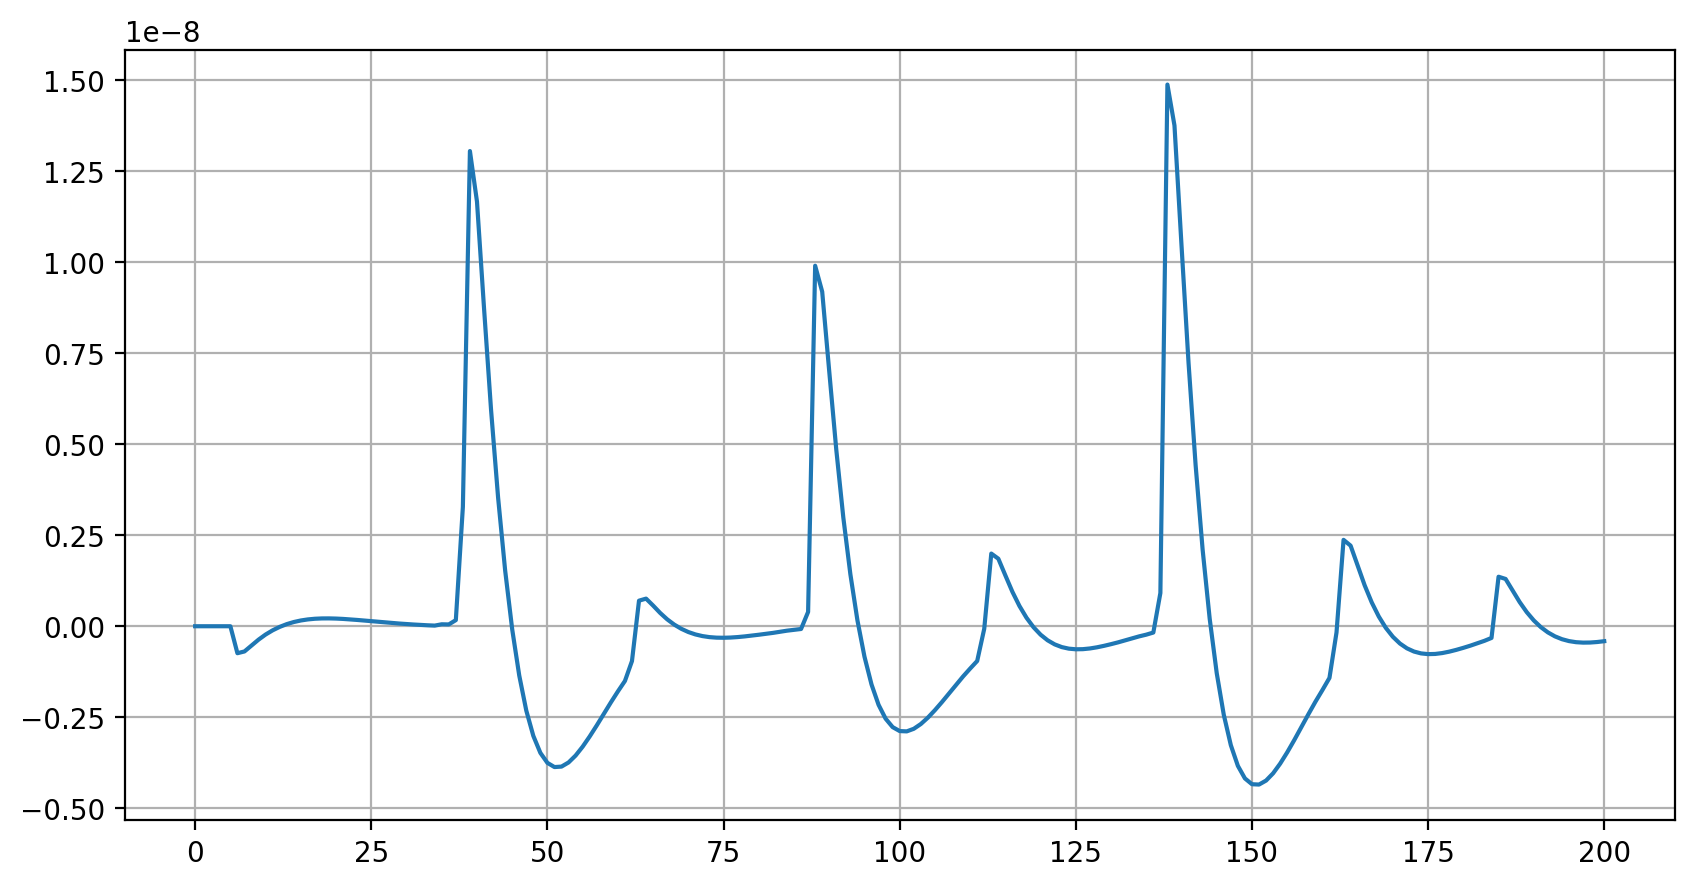

In [ ]:
plt.plot(plant_states[5,:])
plt.show()

In [ ]:
plant_states.shape

(12, 201)

In [ ]:
# max overshoot
overshoot = np.max(np.abs(pos_error), axis=1)
print(f"Max overshoot: {overshoot}")

Max overshoot: [1.12001960e+00 2.09731019e+00 5.41076872e-09]
